# Computational Finance and Financial Management


## Time-series analysis, replication and forecasting of the German TecDAX stock index

By Merlin Bartel and Max Veltwisch

Trying to predict the stock market is an enticing prospect to us, not so much as a desire for material gain, but for the challenge. Looking at the daily up and downs of the market, we imagine there must be patterns we can model to beat all odds. This report follows three main sections:

1. Exploratory analysis on the TecDAX index price data
2. Replication of the TecDAX index price movements by weighting the stocks contained in the index
3. Forecasting the TecDAX index price movements with statistical and deep-learning methods

All sections serve the goal to better understand the index development. Before we start with our research we load the required python packeges into our environment.

In [145]:
#load required packages
import math
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from datetime import timedelta

# import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.losses import mean_squared_error
from keras import optimizers

# 
import statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy import special, optimize

# import facebook prophet
from fbprophet import Prophet

# import sklearn packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



## Exploratory Analysis on German TexDAX Index

In [170]:
# Import and format the Index data

TecDAX = pd.read_csv("TECDAX.csv", index_col=0, parse_dates=True, squeeze=True)
TecDAX = TecDAX["Adj Close"]


In [171]:
TecDAX.describe()


count    3143.000000
mean     1309.951536
std       686.404890
min       405.140015
25%       790.734985
50%       956.710022
75%      1725.950012
max      3039.479980
Name: Adj Close, dtype: float64

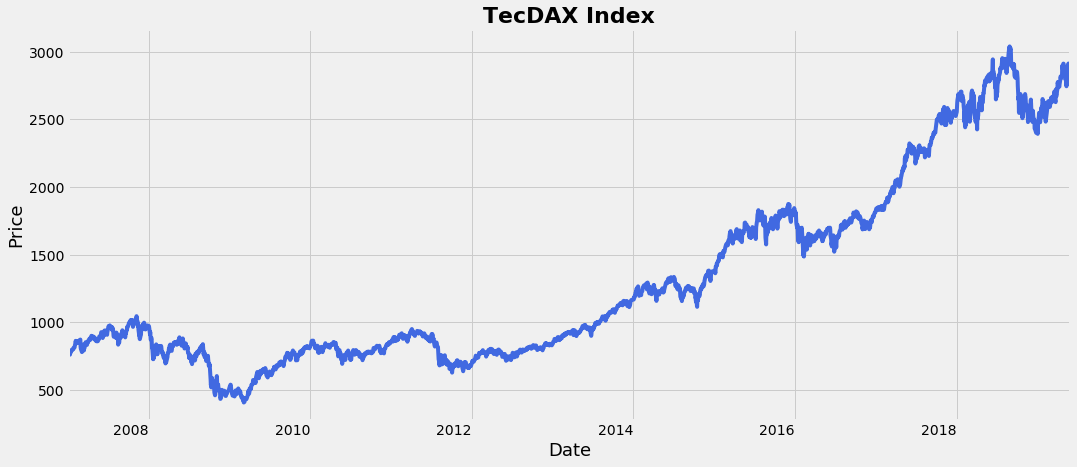

In [172]:
# Plot historical price movement of the TecDAX Index

plt.style.use('fivethirtyeight')

TecDAX.plot(figsize=(16,8), color='royalblue')
plt.xlabel("Date",fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.title("TecDAX Index",fontweight='bold',fontsize=22)
plt.xticks(rotation=0)

plt.show()

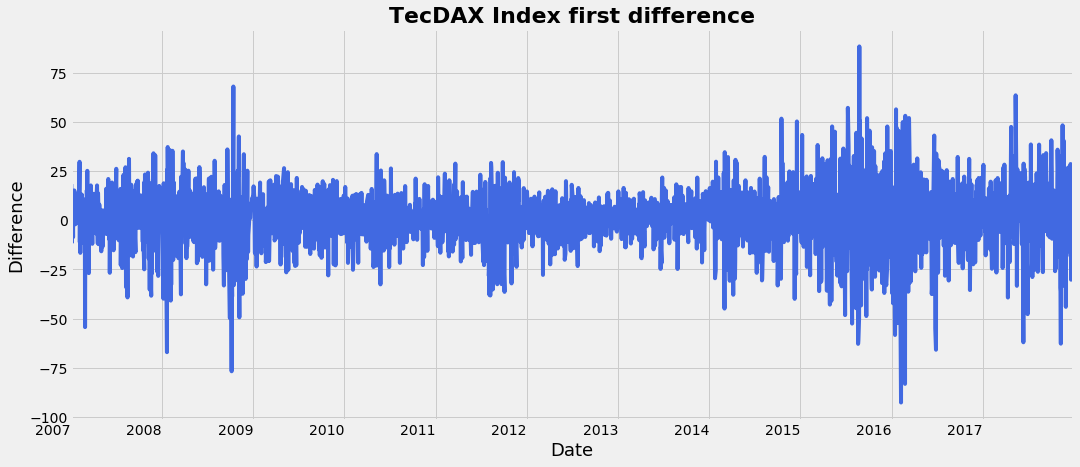

In [173]:
#no stationarity, differencing required
training_diff = training.diff()

# visualising first difference data
training_diff.plot(figsize=(16,8), color='royalblue')
plt.xlabel("Date",fontsize=18,color='black')
plt.ylabel("Difference",fontsize=18,color='black')
plt.title("TecDAX Index first difference", fontweight='bold',fontsize=22)
plt.xticks(rotation=0)

plt.show()

We can see that the Shampoo Sales dataset has a clear trend.

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas. The example below plots the autocorrelation for a large number of lags in the time series.

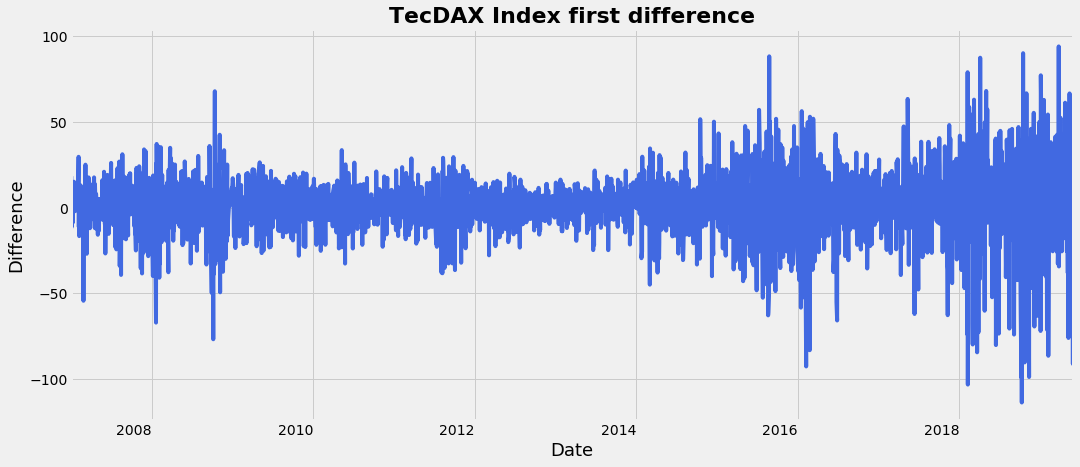

In [174]:
#no stationarity, differencing required
training_diff = TecDAX.diff()

# visualising first difference data
training_diff.plot(figsize=(16,8), color='royalblue')
plt.xlabel("Date",fontsize=18,color='black')
plt.ylabel("Difference",fontsize=18,color='black')
plt.title("TecDAX Index first difference", fontweight='bold',fontsize=22)
plt.xticks(rotation=0)

plt.show()

# Replicating the German TecDAX Index 

hello world

In [153]:
# reading in the data
data = pd.read_csv("Alltogether.csv", encoding='latin-1')
data["Date"] = pd.to_datetime(data["Date"])  

In [154]:
data.set_index("Date", inplace=True)   
data.info()
data.sort_index(inplace=True)       
# data = data.sample(frac=1)  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 992 entries, 2015-01-07 to 2019-05-31
Data columns (total 42 columns):
TecDAX                  992 non-null float64
1&1 Drillisch           992 non-null float64
Aixtron                 992 non-null float64
Aumann                  992 non-null float64
Adva                    992 non-null float64
Bechtle                 992 non-null float64
Cancom                  992 non-null float64
Carl Zeiss Meditec      992 non-null float64
CompuGroup              992 non-null float64
Dialog Semiconductor    992 non-null float64
Drägerwerk              992 non-null float64
Evotec                  992 non-null float64
Freenet                 992 non-null float64
GFT Technologies        992 non-null float64
Infineon                992 non-null float64
Isra                    992 non-null float64
Jenoptik                992 non-null float64
LPKF                    992 non-null float64
Manz                    992 non-null float64
Medigene             

In [155]:
# extract adjusted closing prices (variable to predict)
y = data["TecDAX"]
y = y.values.reshape(len(y),1)
x = data.iloc [0:,1:]
x = x.values.reshape(len(y),41)

In [156]:
train_size = 970
test_size  = len(y) - train_size
y_train, y_test = y[0:train_size], y[train_size:len(y)]
x_train, x_test = x[0:train_size,:], x[train_size:len(y),:]

In [157]:
# implement StandardScaler to normalize features
scaler = StandardScaler()
# use fit_transform to obtain mean and variance for x_train (fit) and then normalize x_train (transform)
x_train = scaler.fit_transform(x_train)
# use transform to normalize x_test 
x_test = scaler.transform(x_test)

In [158]:
train_size2 = int(train_size * 0.7)
valid_size  = train_size - train_size2

x_train.shape
buff = np.append(y_train, x_train, axis =1)
# np.savetxt("foo.csv", y_buff, delimiter=",")
np.random.shuffle(buff)

y_buff = buff[:,0]
x_buff = buff[:,1:]
np.reshape(x_buff, (len(x_buff),41))  
np.reshape(y_buff, (len(x_buff),1))  


y_train, y_valid = y_buff[0:train_size2], y_buff[train_size2:train_size]
x_train, x_valid = x_buff[0:train_size2,:], x_buff[train_size2:train_size,:]

In [159]:
# build neural network

def index_model(n_first,n_second,n_third):
    model = Sequential()
    
    # input layer
    model.add(Dense(n_first,activation='relu',input_dim=x_train.shape[1])) 
    # input_shape can also be used to input the shape for input data 
    # model.add(Dense(n_first,activation='relu',input_shape = (x_train.shape[1],)))
    
    # hidden layers
        # second layer
    model.add(Dense(n_second,activation='relu')) # no need to specify input_dim in hidden layers
        # third layer
    model.add(Dense(n_third, activation='relu'))
    
    # output layer
    model.add(Dense(1)) # Since default activation function is linear/identy, no need to define
    # compilation
    model.compile(optimizer='adam',loss='mae')
    return model

result = pd.DataFrame(columns=['first_hidden','second_hidden','third_hidden','mae'])
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 4 columns):
first_hidden     0 non-null object
second_hidden    0 non-null object
third_hidden     0 non-null object
mae              0 non-null object
dtypes: object(4)
memory usage: 0.0+ bytes


In [160]:
# use for loop to run each combination
for first_layer in [20,30]:
    for second_layer in [12,18]:
        for third_layer in [3,10]:
            model = index_model(first_layer,second_layer,third_layer)
            # train the neural network, validation set is included to check if overfitting occurs
            model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid))
            # get the performance by using validaiton set 
            mae = model.evaluate(x_valid, y_valid)
            # record the details in the result dataframe 
            # use append() function 
            #result = result.append({'first_hidden':first_layer,'second_hidden':second_layer,'third_hidden':third_layer,'mae':mae}, ignore_index=True)
            result=result.append({'first_hidden':first_layer,'second_hidden':second_layer,'third_hidden':third_layer,'mae':mae},ignore_index=True)
            
print(result)

Train on 679 samples, validate on 291 samples
Epoch 1/50
679/679 [==============================] - 1s 1ms/step - loss: 2176.1534 - val_loss: 2201.7581
Epoch 2/50
679/679 [==============================] - 0s 71us/step - loss: 2175.4366 - val_loss: 2200.9157
Epoch 3/50
679/679 [==============================] - 0s 71us/step - loss: 2174.3289 - val_loss: 2199.3153
Epoch 4/50
679/679 [==============================] - 0s 70us/step - loss: 2172.1156 - val_loss: 2195.9024
Epoch 5/50
679/679 [==============================] - 0s 68us/step - loss: 2167.3939 - val_loss: 2188.7720
Epoch 6/50
679/679 [==============================] - 0s 69us/step - loss: 2158.3746 - val_loss: 2176.0967
Epoch 7/50
679/679 [==============================] - 0s 69us/step - loss: 2142.7212 - val_loss: 2153.7819
Epoch 8/50
679/679 [==============================] - 0s 68us/step - loss: 2115.2246 - val_loss: 2116.7780
Epoch 9/50
679/679 [==============================] - 0s 71us/step - loss: 2071.7886 - val_loss: 20

679/679 [==============================] - 1s 1ms/step - loss: 2176.1389 - val_loss: 2201.7554
Epoch 2/50
679/679 [==============================] - 0s 69us/step - loss: 2175.3242 - val_loss: 2200.7640
Epoch 3/50
679/679 [==============================] - 0s 68us/step - loss: 2173.8962 - val_loss: 2198.5690
Epoch 4/50
679/679 [==============================] - 0s 70us/step - loss: 2170.7451 - val_loss: 2193.9014
Epoch 5/50
679/679 [==============================] - 0s 72us/step - loss: 2164.1213 - val_loss: 2183.7024
Epoch 6/50
679/679 [==============================] - 0s 71us/step - loss: 2149.5734 - val_loss: 2162.9034
Epoch 7/50
679/679 [==============================] - 0s 68us/step - loss: 2121.6501 - val_loss: 2124.4639
Epoch 8/50
679/679 [==============================] - 0s 69us/step - loss: 2071.8865 - val_loss: 2057.7490
Epoch 9/50
679/679 [==============================] - 0s 68us/step - loss: 1989.6841 - val_loss: 1952.2937
Epoch 10/50
679/679 [============================

Epoch 3/50
679/679 [==============================] - 0s 74us/step - loss: 2168.9390 - val_loss: 2191.2830
Epoch 4/50
679/679 [==============================] - 0s 70us/step - loss: 2161.8098 - val_loss: 2181.3327
Epoch 5/50
679/679 [==============================] - 0s 73us/step - loss: 2149.5661 - val_loss: 2164.7470
Epoch 6/50
679/679 [==============================] - 0s 72us/step - loss: 2129.5198 - val_loss: 2138.1807
Epoch 7/50
679/679 [==============================] - 0s 72us/step - loss: 2097.8923 - val_loss: 2097.1495
Epoch 8/50
679/679 [==============================] - 0s 73us/step - loss: 2050.0648 - val_loss: 2036.7100
Epoch 9/50
679/679 [==============================] - 0s 74us/step - loss: 1981.1432 - val_loss: 1950.9052
Epoch 10/50
679/679 [==============================] - 0s 77us/step - loss: 1885.2811 - val_loss: 1834.3472
Epoch 11/50
679/679 [==============================] - 0s 73us/step - loss: 1756.6802 - val_loss: 1679.0420
Epoch 12/50
679/679 [==============

679/679 [==============================] - 0s 75us/step - loss: 103.1216 - val_loss: 112.3453
Epoch 30/50
679/679 [==============================] - 0s 76us/step - loss: 99.5566 - val_loss: 108.1308
Epoch 31/50
679/679 [==============================] - 0s 73us/step - loss: 95.1928 - val_loss: 104.0734
Epoch 32/50
679/679 [==============================] - 0s 74us/step - loss: 91.4044 - val_loss: 100.1993
Epoch 33/50
679/679 [==============================] - 0s 74us/step - loss: 89.5676 - val_loss: 97.3519
Epoch 34/50
679/679 [==============================] - 0s 75us/step - loss: 87.0226 - val_loss: 94.0191
Epoch 35/50
679/679 [==============================] - 0s 73us/step - loss: 82.7168 - val_loss: 88.9778
Epoch 36/50
679/679 [==============================] - 0s 74us/step - loss: 79.3434 - val_loss: 85.5304
Epoch 37/50
679/679 [==============================] - 0s 72us/step - loss: 76.9135 - val_loss: 82.4305
Epoch 38/50
679/679 [==============================] - 0s 72us/step - l

In [161]:
# first is to know which combination provides the minimized mae 
# use idxmin() function to check 
min_index = result['mae'].idxmin()
# will return the index number 
print(min_index)

5


In [162]:
first_hidden_best = result['first_hidden'][min_index]
second_hidden_best = result['second_hidden'][min_index]
third_hidden_best = result['third_hidden'][min_index]

print("Optimized number for the first layer is ",first_hidden_best)
print("Optimized number for the second layer is ",second_hidden_best)
print("Optimized number for the third layer is ",third_hidden_best)

Optimized number for the first layer is  30.0
Optimized number for the second layer is  12.0
Optimized number for the third layer is  10.0


In [163]:
# first, change the hidden_best from float back to integer
first_hidden_best  = int(first_hidden_best)
second_hidden_best = int(second_hidden_best)
third_hidden_best  = int(third_hidden_best)

# then train the model again
min_model = index_model(first_hidden_best,second_hidden_best,third_hidden_best)
min_model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid))
min_mae = min_model.evaluate(x_test, y_test)

print("Mean absolute Error for the test set: ", min_mae)

Train on 679 samples, validate on 291 samples
Epoch 1/50
679/679 [==============================] - 1s 2ms/step - loss: 2175.8624 - val_loss: 2201.3041
Epoch 2/50
679/679 [==============================] - 0s 85us/step - loss: 2174.6506 - val_loss: 2199.5974
Epoch 3/50
679/679 [==============================] - 0s 83us/step - loss: 2172.1808 - val_loss: 2195.6612
Epoch 4/50
679/679 [==============================] - 0s 80us/step - loss: 2166.1302 - val_loss: 2185.9336
Epoch 5/50
679/679 [==============================] - 0s 82us/step - loss: 2152.2674 - val_loss: 2165.4420
Epoch 6/50
679/679 [==============================] - 0s 80us/step - loss: 2124.1428 - val_loss: 2124.1927
Epoch 7/50
679/679 [==============================] - 0s 80us/step - loss: 2070.4938 - val_loss: 2048.8477
Epoch 8/50
679/679 [==============================] - 0s 83us/step - loss: 1975.1127 - val_loss: 1921.9779
Epoch 9/50
679/679 [==============================] - 0s 90us/step - loss: 1821.7984 - val_loss: 17

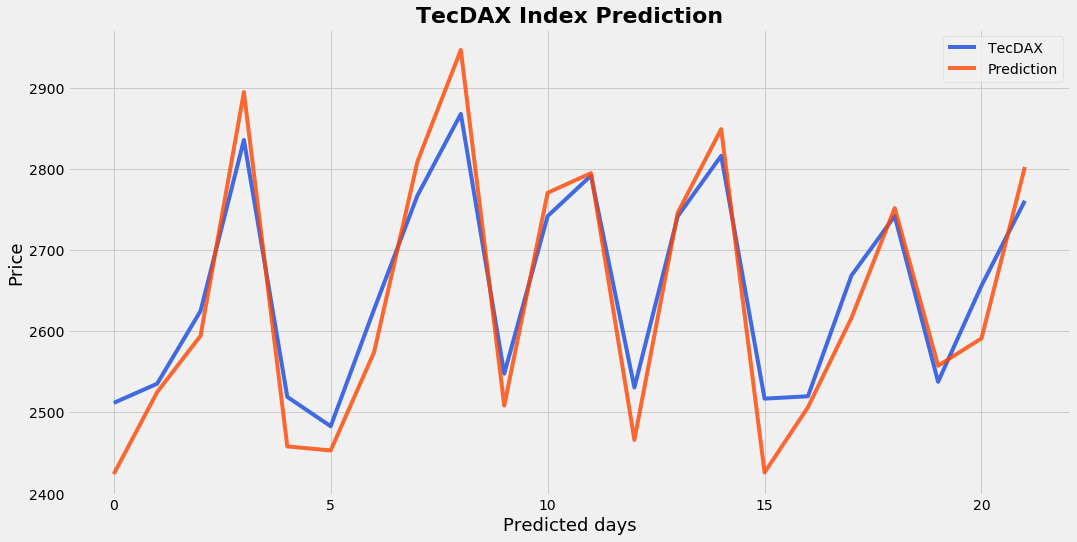

In [164]:
# Visualising the results

# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_level = model.predict(x_test)
# predicted_level = scaler.inverse_transform(predicted_level)
axes = plt.gca()

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(y_test[0:,], color = 'royalblue', label = 'TecDAX')
plt.plot(predicted_level, color = 'orangered', label = "Prediction", alpha = 0.8)
plt.title("TecDAX Index Prediction",fontweight='bold',fontsize=22)
plt.xlabel("Predicted days",fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.legend()
plt.xticks(rotation=0)

plt.show()

# Method 2: Facebook Prophet Model

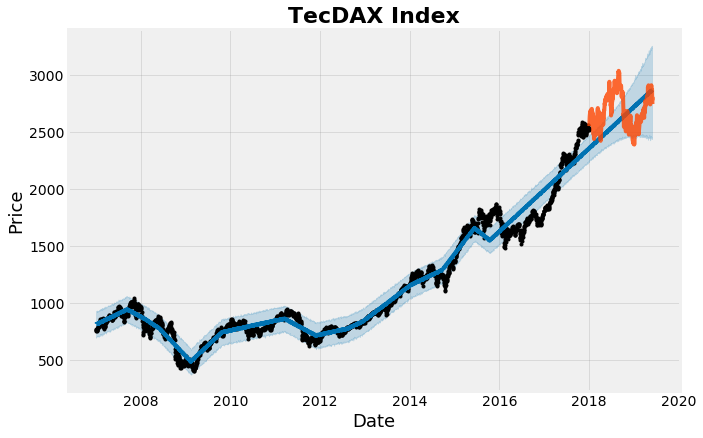

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,self_define_cycle,self_define_cycle_lower,self_define_cycle_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-01-02,815.265724,698.195981,930.859593,815.265724,815.265724,2.831211,2.831211,2.831211,2.831211,2.831211,2.831211,0.0,0.0,0.0,818.096935
1,2007-01-03,815.785685,701.184748,933.588296,815.785685,815.785685,3.848236,3.848236,3.848236,3.848236,3.848236,3.848236,0.0,0.0,0.0,819.633922
2,2007-01-04,816.305647,709.438169,936.627915,816.305647,816.305647,2.655199,2.655199,2.655199,2.655199,2.655199,2.655199,0.0,0.0,0.0,818.960846
3,2007-01-05,816.825608,709.030383,936.160956,816.825608,816.825608,2.317533,2.317533,2.317533,2.317533,2.317533,2.317533,0.0,0.0,0.0,819.143141
4,2007-01-08,818.385492,707.930086,934.281045,818.385492,818.385492,-0.617902,-0.617902,-0.617902,-0.617902,-0.617902,-0.617902,0.0,0.0,0.0,817.767591
5,2007-01-09,818.905454,710.372955,929.915705,818.905454,818.905454,1.163272,1.163272,1.163272,1.163272,1.163272,1.163272,0.0,0.0,0.0,820.068726
6,2007-01-10,819.425415,713.927440,922.350931,819.425415,819.425415,2.087909,2.087909,2.087909,2.087909,2.087909,2.087909,0.0,0.0,0.0,821.513324
7,2007-01-11,819.945377,710.015887,939.661053,819.945377,819.945377,1.301520,1.301520,1.301520,1.301520,1.301520,1.301520,0.0,0.0,0.0,821.246897
8,2007-01-12,820.465338,711.918119,935.169473,820.465338,820.465338,1.699938,1.699938,1.699938,1.699938,1.699938,1.699938,0.0,0.0,0.0,822.165276
9,2007-01-15,822.025222,710.027725,932.434447,822.025222,822.025222,-1.557965,-1.557965,-1.557965,-1.557965,-1.557965,-1.557965,0.0,0.0,0.0,820.467258


In [167]:

def cycle_analysis(data,split_date,cycle,mode='additive',forecast_plot = False,print_ind=False):
    training = data[:split_date].iloc[:-1,]
    testing = data[split_date:]
    predict_period = len(pd.date_range(split_date,max(data.index)))
    df = training.reset_index()
    df.columns = ['ds','y']
    m = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
    m.add_seasonality('self_define_cycle',period=cycle,fourier_order=8,mode=mode)
    m.fit(df)
    future = m.make_future_dataframe(periods=predict_period)
    forecast = m.predict(future)
    if forecast_plot:
        m.plot(forecast)
        plt.plot(testing.index,testing.values,color='orangered',alpha=0.8)
        plt.title("TecDAX Index",fontweight='bold',fontsize=22)
        plt.xlabel('Date',fontsize=18,color='black')
        plt.ylabel('Price',fontsize=18,color='black')
        plt.show()
    ret = max(forecast.self_define_cycle)-min(forecast.self_define_cycle)
    model_tb = forecast['yhat']
    model_tb.index = forecast['ds'].map(lambda x:x.strftime("%Y-%m-%d"))
    return forecast

       
cycle_analysis(TecDAX,'2018-01-02',30,forecast_plot=True,print_ind=True)
